In this notebook, we will build a 3D map of a scene from a small set of images and then localize an image downloaded from the Internet. This demo was contributed by [Philipp Lindenberger](https://github.com/Phil26AT/).

In [3]:
%load_ext autoreload
%autoreload 2
import tqdm, tqdm.notebook
tqdm.tqdm = tqdm.notebook.tqdm  # notebook-friendly progress bars
from pathlib import Path
import numpy as np

from hloc import extract_features, match_features, reconstruction, visualization, pairs_from_exhaustive
from hloc.visualization import plot_images, read_image
from hloc.utils import viz_3d

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setup
Here we define some output paths.

In [4]:
matcher_conf = match_features.confs['lightglue_gim']

In [9]:
images = Path('datasets/sacre_coeur')
outputs = Path('outputs/demo/')
!rm -rf $outputs
sfm_pairs = outputs / 'pairs-sfm.txt'
loc_pairs = outputs / 'pairs-loc.txt'
sfm_dir = outputs / 'sfm'
features = outputs / 'features.h5'
matches = outputs / 'matches.h5'

feature_conf = extract_features.confs['superpoint_max']
# matcher_conf = match_features.confs['superpoint+lightglue']
matcher_conf = match_features.confs['lightglue_gim']

# 3D mapping
First we list the images used for mapping. These are all day-time shots of Sacre Coeur.

10 mapping images


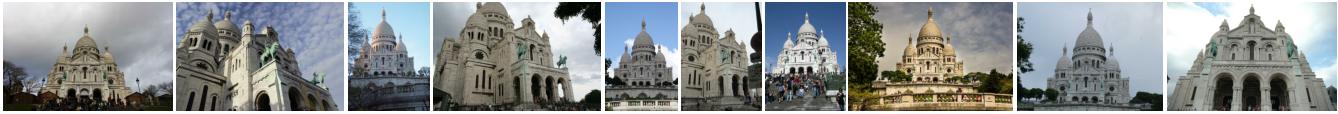

In [11]:
references = [p.relative_to(images).as_posix() for p in (images / 'mapping/').iterdir()]
print(len(references), "mapping images")
plot_images([read_image(images / r) for r in references], dpi=25)

Then we extract features and match them across image pairs. Since we deal with few images, we simply match all pairs exhaustively. For larger scenes, we would use image retrieval, as demonstrated in the other notebooks.

In [12]:
extract_features.main(feature_conf, images, image_list=references, feature_path=features)


[2025/10/15 16:28:17 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-rmax1600',
 'preprocessing': {'grayscale': True, 'resize_force': True, 'resize_max': 1600}}


Loaded SuperPoint model


  0%|          | 0/10 [00:00<?, ?it/s]

[2025/10/15 16:28:45 hloc INFO] Finished exporting features.


PosixPath('outputs/demo/features.h5')

In [5]:
for i, n1 in enumerate(references):
    print(i, n1)

0 mapping/44120379_8371960244.jpg
1 mapping/32809961_8274055477.jpg
2 mapping/51091044_3486849416.jpg
3 mapping/10265353_3838484249.jpg
4 mapping/71295362_4051449754.jpg
5 mapping/60584745_2207571072.jpg
6 mapping/02928139_3448003521.jpg
7 mapping/17295357_9106075285.jpg
8 mapping/93341989_396310999.jpg
9 mapping/03903474_1471484089.jpg


In [6]:
sfm_pairs

PosixPath('outputs/demo/pairs-sfm.txt')

In [13]:
pairs_from_exhaustive.main(sfm_pairs, image_list=references)


[2025/10/15 16:31:04 hloc INFO] Found 45 pairs.


- lightglue:

    - 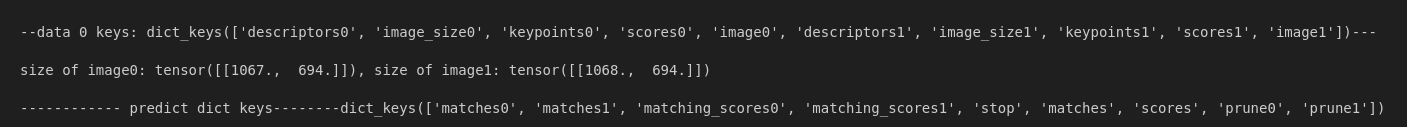
    - 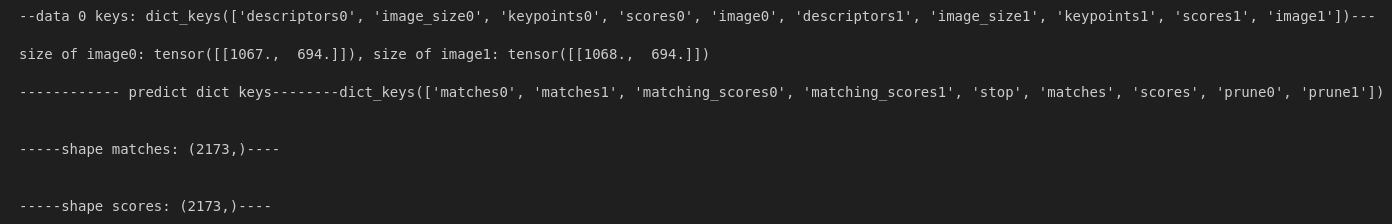

- lightglue_gim:
    - 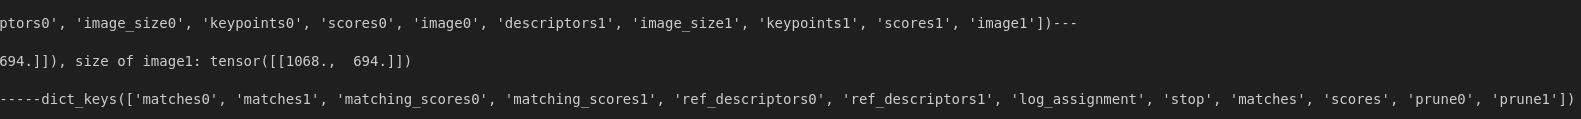
    - 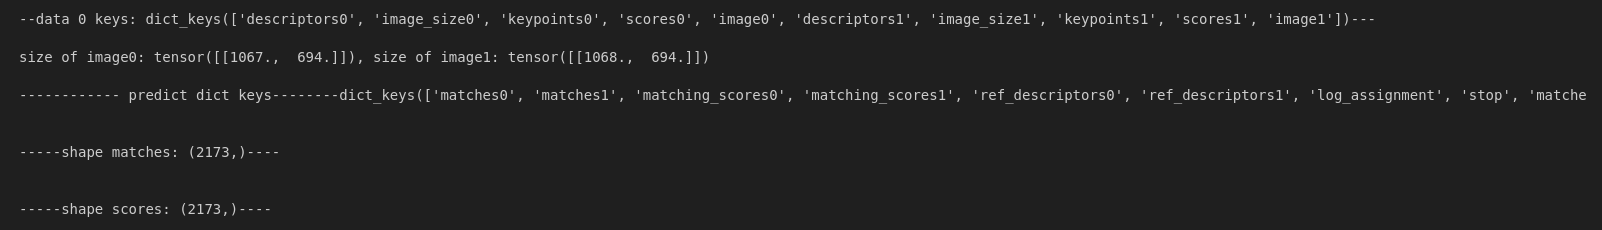


In [14]:
match_features.main(matcher_conf, sfm_pairs, features=features, matches=matches)

[2025/10/15 16:31:06 hloc INFO] Matching local features with configuration:
{'model': {'name': 'lightglue_gim'}, 'output': 'matches-lightglue_gim'}


  0%|          | 0/45 [00:00<?, ?it/s]


--data 0 keys: dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])---


------------ predict dict keys--------dict_keys(['matches0', 'matches1', 'matching_scores0', 'matching_scores1', 'ref_descriptors0', 'ref_descriptors1', 'log_assignment', 'stop', 'matches', 'scores', 'prune0', 'prune1'])


-----shape matches: (3172,)----

Datasets in group: ['matches0']

-----shape scores: (3172,)----

Datasets in group: ['matches0', 'matching_scores0']

--data 0 keys: dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])---


------------ predict dict keys--------dict_keys(['matches0', 'matches1', 'matching_scores0', 'matching_scores1', 'ref_descriptors0', 'ref_descriptors1', 'log_assignment', 'stop', 'matches', 'scores', 'prune0', 'prune1'])


-----shape matches: (3079,)----

Datasets in group: ['matches0']

-----sha

[2025/10/15 16:37:28 hloc INFO] Finished exporting matches.



------------ predict dict keys--------dict_keys(['matches0', 'matches1', 'matching_scores0', 'matching_scores1', 'ref_descriptors0', 'ref_descriptors1', 'log_assignment', 'stop', 'matches', 'scores', 'prune0', 'prune1'])


-----shape matches: (3079,)----

Datasets in group: ['matches0']

-----shape scores: (3079,)----

Datasets in group: ['matches0', 'matching_scores0']


PosixPath('outputs/demo/matches.h5')

The we run incremental Structure-From-Motion and display the reconstructed 3D model.

In [15]:
import h5py

In [16]:
dir_matches = "//home//vuthanhdat//VisualLocalization//crocodl-benchmark//external//hloc//outputs//demo//matches.h5"

In [ ]:
# read_file matches.h5

with h5py.File(str(dir_matches), 'r', libver='latest') as hfile:
    print("Keys: %s" % hfile.keys())
    for key in hfile.keys():
        print(key)
    print("\nAttributes:")
    for attr in hfile.attrs:
        print("%s: %s" % (attr, hfile.attrs[attr]))
    print("\nDatasets:")
    for name, dataset in hfile.items():
        print("%s: %s" % (name, dataset))


Keys: <KeysViewHDF5 ['mapping-02928139_3448003521.jpg', 'mapping-10265353_3838484249.jpg', 'mapping-17295357_9106075285.jpg', 'mapping-32809961_8274055477.jpg', 'mapping-44120379_8371960244.jpg', 'mapping-51091044_3486849416.jpg', 'mapping-60584745_2207571072.jpg', 'mapping-71295362_4051449754.jpg', 'mapping-93341989_396310999.jpg']>
mapping-02928139_3448003521.jpg
mapping-10265353_3838484249.jpg
mapping-17295357_9106075285.jpg
mapping-32809961_8274055477.jpg
mapping-44120379_8371960244.jpg
mapping-51091044_3486849416.jpg
mapping-60584745_2207571072.jpg
mapping-71295362_4051449754.jpg
mapping-93341989_396310999.jpg

Attributes:

Datasets:
mapping-02928139_3448003521.jpg: <HDF5 group "/mapping-02928139_3448003521.jpg" (3 members)>
mapping-10265353_3838484249.jpg: <HDF5 group "/mapping-10265353_3838484249.jpg" (6 members)>
mapping-17295357_9106075285.jpg: <HDF5 group "/mapping-17295357_9106075285.jpg" (2 members)>
mapping-32809961_8274055477.jpg: <HDF5 group "/mapping-32809961_8274055477

In [25]:
matches = outputs / 'matches.h5'

In [26]:
model = reconstruction.main(sfm_dir, images, sfm_pairs, features, matches, image_list=references)

[2025/10/15 16:40:44 hloc INFO] Creating an empty database...


[2025/10/15 16:40:44 hloc INFO] Importing images into the database...
[2025/10/15 16:40:45 hloc INFO] Importing features into the database...


  0%|          | 0/10 [00:00<?, ?it/s]

[2025/10/15 16:40:45 hloc INFO] Importing matches into the database...


  0%|          | 0/45 [00:00<?, ?it/s]

[2025/10/15 16:40:45 hloc INFO] Performing geometric verification of the matches...
I20251015 16:40:45.188671 139624806602432 misc.cc:44] 
Feature matching
I20251015 16:40:45.189181 139624823387840 sift.cc:1434] Creating SIFT CPU feature matcher
I20251015 16:40:45.189209 139624814995136 sift.cc:1434] Creating SIFT CPU feature matcher
I20251015 16:40:45.189270 139624798209728 sift.cc:1434] Creating SIFT CPU feature matcher
I20251015 16:40:45.189300 139630517155520 sift.cc:1434] Creating SIFT CPU feature matcher
I20251015 16:40:45.189337 139630473115328 sift.cc:1434] Creating SIFT CPU feature matcher
I20251015 16:40:45.189367 139630395520704 sift.cc:1434] Creating SIFT CPU feature matcher
I20251015 16:40:45.189384 139625530123968 sift.cc:1434] Creating SIFT CPU feature matcher
I20251015 16:40:45.189401 139625326687936 sift.cc:1434] Creating SIFT CPU feature matcher
I20251015 16:40:45.189447 139625318295232 sift.cc:1434] Creating SIFT CPU feature matcher
I20251015 16:40:45.189483 13962530


 --- model path: outputs/demo/sfm/models --- 



I20251015 16:40:45.579327 139631371589120 incremental_pipeline.cc:428] Registering image #5 (num_reg_frames=2)
I20251015 16:40:45.579345 139631371589120 incremental_pipeline.cc:431] => Image sees 224 / 1331 points
I20251015 16:40:45.743600 139631371589120 incremental_pipeline.cc:43] Retriangulation and Global bundle adjustment
I20251015 16:40:45.781022 139631371589120 incremental_pipeline.cc:428] Registering image #3 (num_reg_frames=3)
I20251015 16:40:45.781069 139631371589120 incremental_pipeline.cc:431] => Image sees 843 / 1674 points
I20251015 16:40:45.975523 139631371589120 incremental_pipeline.cc:43] Retriangulation and Global bundle adjustment
I20251015 16:40:46.039056 139631371589120 incremental_pipeline.cc:428] Registering image #1 (num_reg_frames=4)
I20251015 16:40:46.039077 139631371589120 incremental_pipeline.cc:431] => Image sees 519 / 1156 points
I20251015 16:40:46.271034 139631371589120 incremental_pipeline.cc:43] Retriangulation and Global bundle adjustment
I20251015 16:

In [4]:
# read matches.h5
dir_matches = '//home//vuthanhdat//VisualLocalization//crocodl-benchmark//external//hloc//outputs//demo//matches.h5'
with h5py.File(dir_matches, 'r') as f:
    print(f"Keys: {list(f.keys())}")

Keys: ['mapping-02928139_3448003521.jpg', 'mapping-10265353_3838484249.jpg', 'mapping-17295357_9106075285.jpg', 'mapping-32809961_8274055477.jpg', 'mapping-44120379_8371960244.jpg', 'mapping-51091044_3486849416.jpg', 'mapping-60584745_2207571072.jpg', 'mapping-71295362_4051449754.jpg', 'mapping-93341989_396310999.jpg']


In [17]:
with h5py.File(dir_matches, 'r') as f:
    first_key = f['mapping-02928139_3448003521.jpg']
    matches = first_key['mapping-03903474_1471484089.jpg']['matches0'][:]
    print(f"first - 1 - matches0 keys: {first_key['mapping-03903474_1471484089.jpg'].keys()}")

first - 1 - matches0 keys: <KeysViewHDF5 ['matches0', 'matching_scores0']>


In [24]:
# find the index where matches != -1
matches[matches != -1]

array([   6,    8,   12,   16,   24,   42,   49,   41,   66,   67,   63,
         98,  101,  118,  112,  130,  126,  128,  121,  125,  124,  142,
        140,  144,  256,  254,  329,  149,  262,  165,  168,  159,  157,
        163,  369,  161,  176,  265,  137,  156,  162,  155,  180,  187,
        186,  300,  152,  295,  301,  225,  211,  212,  174,  179,  189,
        207,  195,  204,  200,  238,  250,  249,  237,  242,  199,  243,
        226,  223,  208,  229,  274,  522,  197,  222,  206,  280,  240,
        268,  266,  231,  270,  267,  239,  236,  283,  220,  278,  227,
        216,  219,  310,  263,  396,  260,  420,  258,  303,  282,  306,
        302,  304,  309,  583,  307,  273,  255,  259,  257,  361,  333,
        349,  286,  343,  320,  285,  311,  318,  488,  347,  648,  315,
        291,  325,  581,  341,  293,  375,  332,  352,  393,  518,  400,
        324,  418,  411,  367,  384,  432,  428,  413,  398,  544,  399,
        455,  427,  450,  405,  560,  472,  366,  4

In [28]:
import sqlite3
from pprint import pprint

db_path = "//home//vuthanhdat//VisualLocalization//crocodl-benchmark//external//hloc//outputs//demo//sfm//database.db"
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Xem các bảng có trong DB
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("📂 Tables trong database:", tables)

# Ví dụ: xem ảnh
cursor.execute("SELECT image_id, name, camera_id FROM images;")
pprint(cursor.fetchall())

# Xem camera
cursor.execute("SELECT * FROM cameras;")
pprint(cursor.fetchall())

# Xem số lượng feature
cursor.execute("SELECT COUNT(*) FROM keypoints;")
print("Số keypoints:", cursor.fetchone()[0])

# Xem số lượng match
cursor.execute("SELECT COUNT(*) FROM two_view_geometries;")
print("Số lượng cặp match:", cursor.fetchone()[0])

conn.close()


📂 Tables trong database: [('cameras',), ('sqlite_sequence',), ('images',), ('keypoints',), ('descriptors',), ('matches',), ('two_view_geometries',), ('rigs',), ('rig_sensors',), ('frames',), ('frame_data',), ('pose_priors',)]
[(1, 'mapping/02928139_3448003521.jpg', 1),
 (2, 'mapping/03903474_1471484089.jpg', 2),
 (3, 'mapping/10265353_3838484249.jpg', 3),
 (4, 'mapping/17295357_9106075285.jpg', 4),
 (5, 'mapping/32809961_8274055477.jpg', 5),
 (6, 'mapping/44120379_8371960244.jpg', 6),
 (7, 'mapping/51091044_3486849416.jpg', 7),
 (8, 'mapping/60584745_2207571072.jpg', 8),
 (9, 'mapping/71295362_4051449754.jpg', 9),
 (10, 'mapping/93341989_396310999.jpg', 10)]
[(1,
  2,
  780,
  1063,
  b'fffff\xee\x93@\x00\x00\x00\x00\x00`x@\x00\x00\x00\x00\x00\x9c\x80@'
  b'\x00\x00\x00\x00\x00\x00\x00\x00',
  0),
 (2,
  2,
  1080,
  695,
  b'\x00\x00\x00\x00\x00@\x94@\x00\x00\x00\x00\x00\xe0\x80@\x00\x00\x00\x00'
  b'\x00\xb8u@\x00\x00\x00\x00\x00\x00\x00\x00',
  0),
 (3,
  2,
  1068,
  694,
  b'fffff

In [29]:
db_path = "//home//vuthanhdat//VisualLocalization//crocodl-benchmark//external//hloc//outputs//demo//sfm//database.db"
conn = sqlite3.connect(db_path)
cursor = conn.cursor()
# xem bảng matches
cursor.execute("SELECT * FROM matches;")
pprint(cursor.fetchall())

conn.close()

[(2147483649,
  489,
  2,
  b'\x9e\x01\x00\x00\x06\x00\x00\x00\xbc\x01\x00\x00\x08\x00\x00\x00'
  b'\xca\x01\x00\x00\x0c\x00\x00\x00\xdb\x01\x00\x00\x10\x00\x00\x00'
  b'\x10\x02\x00\x00\x18\x00\x00\x00j\x02\x00\x00*\x00\x00\x00x\x02\x00\x00'
  b'1\x00\x00\x00}\x02\x00\x00)\x00\x00\x00\xec\x02\x00\x00B\x00\x00\x00'
  b'\xfd\x02\x00\x00C\x00\x00\x00Q\x05\x00\x00?\x00\x00\x00\x8e\x05\x00\x00'
  b'b\x00\x00\x00\xa4\x05\x00\x00e\x00\x00\x00\xb4\x05\x00\x00v\x00\x00\x00'
  b'\xb9\x05\x00\x00p\x00\x00\x00\xe1\x05\x00\x00\x82\x00\x00\x00'
  b'\xe2\x05\x00\x00~\x00\x00\x00\xe7\x05\x00\x00\x80\x00\x00\x00'
  b'\xef\x05\x00\x00y\x00\x00\x00\xf1\x05\x00\x00}\x00\x00\x00\xfb\x05\x00\x00'
  b'|\x00\x00\x00\x04\x06\x00\x00\x8e\x00\x00\x00\x08\x06\x00\x00'
  b'\x8c\x00\x00\x00\x12\x06\x00\x00\x90\x00\x00\x00\x15\x06\x00\x00'
  b'\x00\x01\x00\x00"\x06\x00\x00\xfe\x00\x00\x00-\x06\x00\x00I\x01\x00\x00'
  b'/\x06\x00\x00\x95\x00\x00\x005\x06\x00\x00\x06\x01\x00\x00:\x06\x00\x00'
  b'\xa5\x00\x00\x00B\x0

In [30]:

fig = viz_3d.init_figure()
viz_3d.plot_reconstruction(fig, model, color='rgba(255,0,0,0.5)', name="mapping", points_rgb=True)
fig.show()

We also visualize which keypoints were triangulated into the 3D model.

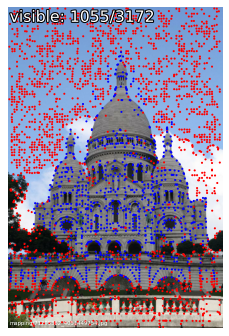

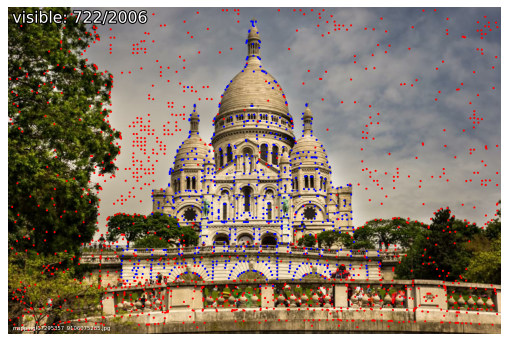

In [31]:
visualization.visualize_sfm_2d(model, images, color_by='visibility', n=2)

# Localization
Now that we have a 3D map of the scene, we can localize any image. To demonstrate this, we download [a night-time image from Wikimedia](https://commons.wikimedia.org/wiki/File:Paris_-_Basilique_du_Sacr%C3%A9_Coeur,_Montmartre_-_panoramio.jpg).

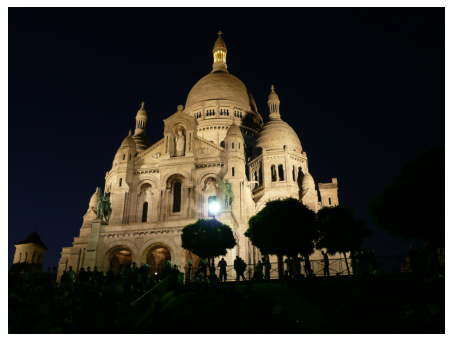

In [32]:
url = "https://upload.wikimedia.org/wikipedia/commons/5/53/Paris_-_Basilique_du_Sacr%C3%A9_Coeur%2C_Montmartre_-_panoramio.jpg"
# try other queries by uncommenting their url
# url = "https://upload.wikimedia.org/wikipedia/commons/5/59/Basilique_du_Sacr%C3%A9-C%C5%93ur_%285430392880%29.jpg"
# url = "https://upload.wikimedia.org/wikipedia/commons/8/8e/Sacr%C3%A9_C%C5%93ur_at_night%21_%285865355326%29.jpg"
query = 'query/night.jpg'
!mkdir -p $images/query && wget $url -O $images/$query -q
plot_images([read_image(images / query)], dpi=75)

Again, we extract features for the query and match them exhaustively.

In [33]:
extract_features.main(feature_conf, images, image_list=[query], feature_path=features, overwrite=True)
pairs_from_exhaustive.main(loc_pairs, image_list=[query], ref_list=references)
match_features.main(matcher_conf, loc_pairs, features=features, matches=matches, overwrite=True);

[2025/10/15 16:41:47 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-rmax1600',
 'preprocessing': {'grayscale': True, 'resize_force': True, 'resize_max': 1600}}


Loaded SuperPoint model


  0%|          | 0/1 [00:00<?, ?it/s]

/home/vuthanhdat/anaconda3/envs/croco/lib/python3.10/site-packages/torch/utils/data/dataloader.py:666: UserWarning:

'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.

[2025/10/15 16:41:51 hloc INFO] Finished exporting features.
[2025/10/15 16:41:51 hloc INFO] Found 10 pairs.
[2025/10/15 16:41:51 hloc INFO] Matching local features with configuration:
{'model': {'name': 'lightglue_gim'}, 'output': 'matches-lightglue_gim'}


  0%|          | 0/10 [00:00<?, ?it/s]


--data 0 keys: dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])---


------------ predict dict keys--------dict_keys(['matches0', 'matches1', 'matching_scores0', 'matching_scores1', 'ref_descriptors0', 'ref_descriptors1', 'log_assignment', 'stop', 'matches', 'scores', 'prune0', 'prune1'])


--data 0 keys: dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])---


-----shape matches: (3469,)----

Datasets in group: ['matches0']

-----shape scores: (3469,)----

Datasets in group: ['matches0', 'matching_scores0']

------------ predict dict keys--------dict_keys(['matches0', 'matches1', 'matching_scores0', 'matching_scores1', 'ref_descriptors0', 'ref_descriptors1', 'log_assignment', 'stop', 'matches', 'scores', 'prune0', 'prune1'])


-----shape matches: (3469,)----

Datasets in group: ['matches0']

-----sha

[2025/10/15 16:43:27 hloc INFO] Finished exporting matches.



------------ predict dict keys--------dict_keys(['matches0', 'matches1', 'matching_scores0', 'matching_scores1', 'ref_descriptors0', 'ref_descriptors1', 'log_assignment', 'stop', 'matches', 'scores', 'prune0', 'prune1'])


-----shape matches: (3469,)----

Datasets in group: ['matches0']

-----shape scores: (3469,)----

Datasets in group: ['matches0', 'matching_scores0']


In [12]:
extract_features.main(feature_conf, images, image_list=[query], feature_path=features, overwrite=True)
pairs_from_exhaustive.main(loc_pairs, image_list=[query], ref_list=references)
match_features.main(matcher_conf, loc_pairs, features=features, matches=matches, overwrite=True);

[2025/10/14 17:23:47 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-rmax1600',
 'preprocessing': {'grayscale': True, 'resize_force': True, 'resize_max': 1600}}


Loaded SuperPoint model


  0%|          | 0/1 [00:00<?, ?it/s]

/home/vuthanhdat/anaconda3/envs/croco/lib/python3.10/site-packages/torch/utils/data/dataloader.py:666: UserWarning:

'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.

[2025/10/14 17:23:51 hloc INFO] Finished exporting features.
[2025/10/14 17:23:51 hloc INFO] Found 10 pairs.
[2025/10/14 17:23:51 hloc INFO] Matching local features with configuration:
{'model': {'features': 'superpoint', 'name': 'lightglue'},
 'output': 'matches-superpoint-lightglue'}


  0%|          | 0/10 [00:00<?, ?it/s]


--data 0 keys: dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])---

size of image0: tensor([[2816., 2112.]]), size of image1: tensor([[ 761., 1015.]])

------------ predict dict keys--------dict_keys(['matches0', 'matches1', 'matching_scores0', 'matching_scores1', 'stop', 'matches', 'scores', 'prune0', 'prune1'])


--data 0 keys: dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])---

size of image0: tensor([[2816., 2112.]]), size of image1: tensor([[ 780., 1063.]])

------------ predict dict keys--------dict_keys(['matches0', 'matches1', 'matching_scores0', 'matching_scores1', 'stop', 'matches', 'scores', 'prune0', 'prune1'])


--data 0 keys: dict_keys(['descriptors0', 'image_size0', 'keypoints0', 'scores0', 'image0', 'descriptors1', 'image_size1', 'keypoints1', 'scores1', 'image1'])---

size of imag

[2025/10/14 17:24:22 hloc INFO] Finished exporting matches.



------------ predict dict keys--------dict_keys(['matches0', 'matches1', 'matching_scores0', 'matching_scores1', 'stop', 'matches', 'scores', 'prune0', 'prune1'])



We read the EXIF data of the query to infer a rough initial estimate of camera parameters like the focal length. Then we estimate the absolute camera pose using PnP+RANSAC and refine the camera parameters.

found 772/1514 inlier correspondences.


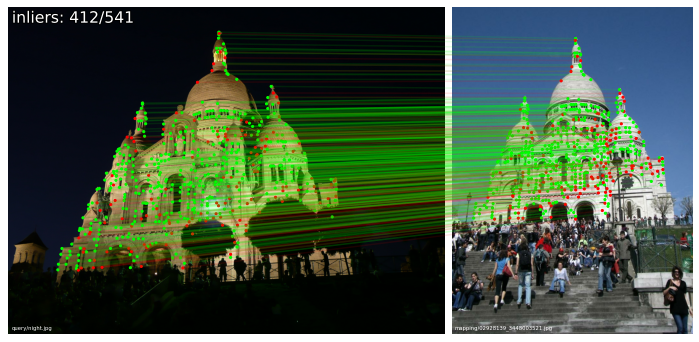

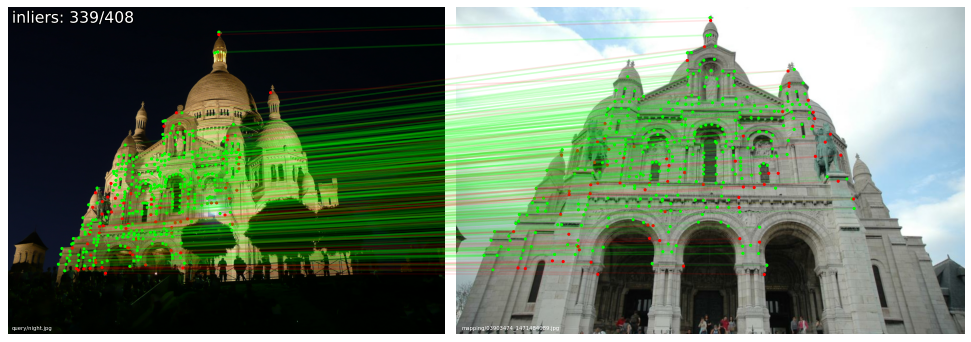

In [34]:
import pycolmap
from hloc.localize_sfm import QueryLocalizer, pose_from_cluster

camera = pycolmap.infer_camera_from_image(images / query)
ref_ids = [model.find_image_with_name(r).image_id for r in references]
conf = {
    'estimation': {'ransac': {'max_error': 12}},
    'refinement': {'refine_focal_length': True, 'refine_extra_params': True},
}
localizer = QueryLocalizer(model, conf)
ret, log = pose_from_cluster(localizer, query, camera, ref_ids, features, matches)
# print(f'found {ret["num_inliers"]}/{len(ret["inliers"])} inlier correspondences.')
print(f'found {ret["num_inliers"]}/{len(ret["inlier_mask"])} inlier correspondences.')
visualization.visualize_loc_from_log(images, query, log, model)

found 750/1368 inlier correspondences.


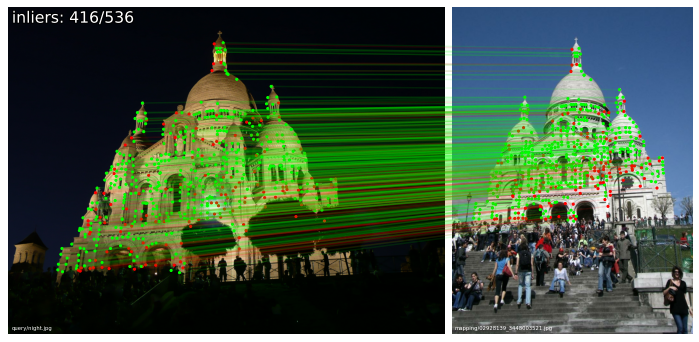

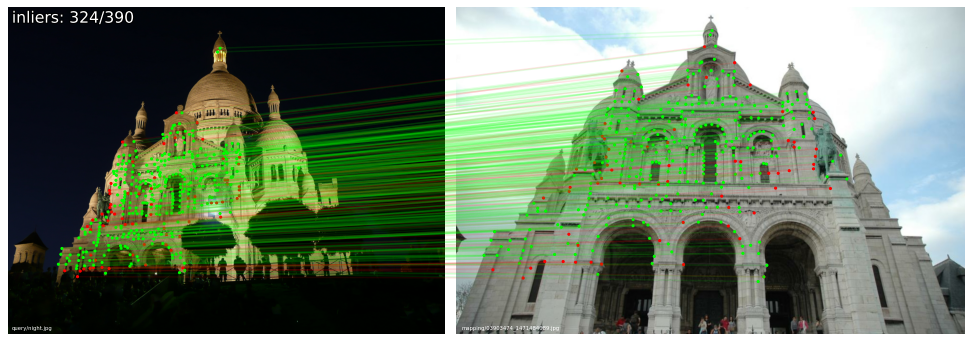

In [23]:
import pycolmap
from hloc.localize_sfm import QueryLocalizer, pose_from_cluster

camera = pycolmap.infer_camera_from_image(images / query)
ref_ids = [model.find_image_with_name(r).image_id for r in references]
conf = {
    'estimation': {'ransac': {'max_error': 12}},
    'refinement': {'refine_focal_length': True, 'refine_extra_params': True},
}
localizer = QueryLocalizer(model, conf)
ret, log = pose_from_cluster(localizer, query, camera, ref_ids, features, matches)
# print(f'found {ret["num_inliers"]}/{len(ret["inliers"])} inlier correspondences.')
print(f'found {ret["num_inliers"]}/{len(ret["inlier_mask"])} inlier correspondences.')
visualization.visualize_loc_from_log(images, query, log, model)

In [19]:
ret

{'cam_from_world': Rigid3d(rotation_xyzw=[0.0421896, 0.44351, -0.16345, 0.880229], translation=[-1.42159, -0.454404, -2.21515]),
 'num_inliers': 750,
 'inlier_mask': array([ True, False,  True, ...,  True, False, False]),
 'camera': {'model': 'SIMPLE_RADIAL',
  'width': 2816,
  'height': 2112,
  'params': array([ 2.86788194e+03,  1.40800000e+03,  1.05600000e+03, -2.98489796e-02])}}

We visualize the correspondences between the query images a few mapping images. We can also visualize the estimated camera pose in the 3D map.

In [67]:
ret['cam_from_world'].translation

array([-1.42180006, -0.45541988, -2.21440337])

In [66]:
ret['cam_from_world'].rotation.matrix()

array([[ 0.55313907,  0.3251827 ,  0.76700286],
       [-0.25048347,  0.94298969, -0.219154  ],
       [-0.79454088, -0.0708989 ,  0.60305733]])

In [56]:
ret['cam_from_world'].rotation.quat

array([ 0.04210715,  0.44350685, -0.16349967,  0.88022527])

In [71]:
ret['cam_from_world'].rotation

Rotation3d(xyzw=[0.0421071, 0.443507, -0.1635, 0.880225])

In [46]:
t = ret['cam_from_world'].translation
r = ret['cam_from_world'].rotation.quat
# Tạo image trống
img = pycolmap.Image(name=query)



In [ ]:
img.cam_from_world

<bound method pybind11_detail_function_record_v1_system_libstdcpp_gxx_abi_1xxx_use_cxx11_abi_1.cam_from_world of Image(image_id=Invalid, camera_id=Invalid, name="query/night.jpg", has_pose=0, triangulated=0/0)>

In [35]:
pose = ret['cam_from_world']  # Rigid3d
R = pose.rotation.matrix()    # 3x3
t = pose.translation          # (3,)

viz_3d.plot_camera(
    fig,
    R.T,                      # world_from_cam → cần transpose
    -R.T @ t,                 # chuyển t từ camera→world
    camera.calibration_matrix(),
    color='rgba(0,255,0,0.5)',
    name=query,
    text='Query Camera',
    size=0.2,
)

In [36]:
fig.show()

In [72]:
pose = ret['cam_from_world']  # Rigid3d
R = pose.rotation.matrix()    # 3x3
t = pose.translation          # (3,)

viz_3d.plot_camera(
    fig,
    R.T,                      # world_from_cam → cần transpose
    -R.T @ t,                 # chuyển t từ camera→world
    camera.calibration_matrix(),
    color='rgba(0,255,0,0.5)',
    name=query,
    text='Query Camera',
    size=0.2,
)

In [73]:
fig.show()

In [ ]:
pose = pycolmap.Image(tvec=ret['cam_from_world'].translation, qvec=ret['cam_from_world'].rotation.quat)

viz_3d.plot_camera_colmap(fig, pose, camera, color='rgba(0,255,0,0.5)', name=query, fill=True)
# visualize 2D-3D correspodences
inl_3d = np.array([model.points3D[pid].xyz for pid in np.array(log['points3D_ids'])[ret['inlier_mask']]])
viz_3d.plot_points(fig, inl_3d, color="lime", ps=1, name=query)
fig.show()

E20251014 21:45:02.887913 123765760501248 helpers.h:110] Internal AttributeError: 'pycolmap._core.Image' object has no attribute 'tvec'


AttributeError: 'pycolmap._core.Image' object has no attribute 'tvec'